### Librerías necesarias

In [1]:
import os
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights, ResNet34_Weights, ResNet50_Weights
import pandas as pd
from PIL import Image
import numpy as np
from IPython.display import display, clear_output
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from fpdf import FPDF

Constantes relacionadas con el conjunto de datos y la ejecución

In [2]:
DESCRIPTION = 'Entrenamiento con ResNet18'
TRAINING_DATE = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
DIR_RESULTS = 'Results'
DIR_CSV = 'C:\\Users\\David\\TFG\\CXR8'
DIR_IMAGES = 'C:\\Users\\David\\TFG\\images'
CSV_TRAINING = 'Data_Entry_2017_v2020.csv'
COLUMN_IMAGE = 'Image Index'
COLUMN_LABELS = 'Finding Labels'
LABEL_NO_FINDING = 'No Finding'

Constantes relacionadas con parámetros del entrenamiento

In [3]:
NUM_EPOCHS = 20
BATCH_SIZE = 32
THRESHOLD = 0.5
LEARNING_RATE = 0.001
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_STATE = 42
SIZE_IMAGES = (250, 250)
DROPOUT_PROB = 0.5
SAMPLES_MC_DROPOUT = 30
UNCERTAINTY_THRESHOLD = 0.05
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Carga de los datos.

Carga el dataset con las etiquetas y datos de cada radiografía y lo muestra.

In [4]:
df_xrays = pd.read_csv(os.path.join(DIR_CSV, CSV_TRAINING))
df_xrays

Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_001.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                57              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                80              M            PA                 2500   
4                74              F            PA                 2500   
...             ...            ...           ...                  ...   
112115           38              M            PA                 2048   
112116           28              M            PA                 2048   
112117           42              F            PA                 2048   
112118           29              F            PA                 2048   
112119           26              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  
0          2749                        0.143  0.143  
1          2729                        0.143  0.143  
2          2048                        0.168  0.168  
3          2048                        0.171  0.171  
4          2048                        0.168  0.168  
...         ...                          ...    ...  
112115     2500                        0.168  0.168  
112116     2500                        0.168  0.168  
112117     2500                        0.168  0.168  
112118     2500                        0.168  0.168  
112119     2500                        0.171  0.171  

[112120 rows x 11 columns]

Obtiene las distintas etiquetas.

In [5]:
#  Recupera los valores de las clases, pero sin repetirse y ordenados alfabéticamente.
labels_names = list(set(label for labels in df_xrays[COLUMN_LABELS].unique() for label in labels.split('|')))
labels_names = np.sort(labels_names)

#  La etiqueta que representa que no hay enfermedad la vamos a tratar de forma diferente.
# En realidad esto sería que no hay ninguna etiqueta de enfermedad. No tendría sentido que
# se pudiera dar, por ejemplo, 'no finding|pneumonia'. Por lo tanto hay que eliminarla.
# La forma que menos problemas ha dado, es al principio dejarla como una etiqueta más.
# Una vez binarizadas las etiquetas, eliminar la columna.
labels_names = np.concatenate(((np.delete(labels_names, np.where(labels_names == LABEL_NO_FINDING)[0]), [LABEL_NO_FINDING])))

#  Cuenta las clases. Restamos la del 'No finding'.
num_labels = len(labels_names) - 1

### Arreglo de los datos.

Código para pruebas, cuando no se trabaja con todo el conjunto de imágenes.

Mira los archivos que hay en el directorio de imágenes y selecciona sólo las filas correctas del dataframe.

In [6]:
list_xrays = os.listdir(DIR_IMAGES)
df_xrays = df_xrays[df_xrays[COLUMN_IMAGE].isin(list_xrays)].copy()
del list_xrays

Agrega la ruta del directorio de las imágenes al nombre de cada una.

In [7]:
df_xrays[COLUMN_IMAGE] = df_xrays[COLUMN_IMAGE].apply(lambda i: os.path.join(DIR_IMAGES, i))

Binariza las etiquetas en el dataframe.

In [8]:
#  Crear una instancia de MultiLabelBinarizer.
mlb = MultiLabelBinarizer(classes=labels_names)

#  Transforma las clases del dataframe.
vectors_one_hot_from_labels = list(mlb.fit_transform([txt_labels.split('|') for txt_labels in df_xrays[COLUMN_LABELS]]))

#  Elimina la columna correspondiente al 'No finding'.
vectors_one_hot_from_labels = np.delete(vectors_one_hot_from_labels, -1, axis=1)

#  Elimina ahora la etiqueta del 'No finding' de labels_names.
labels_names = np.delete(labels_names, np.where(labels_names == LABEL_NO_FINDING)[0])

#  Actualiza el dataframe.
df_xrays[COLUMN_LABELS] = list(vectors_one_hot_from_labels)

del vectors_one_hot_from_labels
del mlb

Muestra el conjunto resultante.

In [9]:
df_xrays

Image Index  \
0      C:\Users\David\TFG\images\00000001_000.png   
1      C:\Users\David\TFG\images\00000001_001.png   
2      C:\Users\David\TFG\images\00000001_002.png   
3      C:\Users\David\TFG\images\00000002_000.png   
4      C:\Users\David\TFG\images\00000003_001.png   
...                                           ...   
74994  C:\Users\David\TFG\images\00018387_030.png   
74995  C:\Users\David\TFG\images\00018387_031.png   
74996  C:\Users\David\TFG\images\00018387_032.png   
74997  C:\Users\David\TFG\images\00018387_033.png   
74998  C:\Users\David\TFG\images\00018387_034.png   

                                   Finding Labels  Follow-up #  Patient ID  \
0      [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            0           1   
1      [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]            1           1   
2      [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]            2           1   
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]            0           2   
4      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]            0           3   
...                                           ...          ...         ...   
74994  [1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]           30       18387   
74995  [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]           31       18387   
74996  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]           32       18387   
74997  [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]           33       18387   
74998  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]           34       18387   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0               57              M            PA                 2682     2749   
1               58              M            PA                 2894     2729   
2               58              M            PA                 2500     2048   
3               80              M            PA                 2500     2048   
4               74              F            PA                 2500     2048   
...            ...            ...           ...                  ...      ...   
74994           58              M            AP                 2500     2048   
74995           58              M            AP                 2500     2048   
74996           59              M            PA                 2532     3056   
74997           59              M            PA                 2992     2991   
74998           59              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  
0                            0.143  0.143  
1                            0.143  0.143  
2                            0.168  0.168  
3                            0.171  0.171  
4                            0.168  0.168  
...                            ...    ...  
74994                        0.168  0.168  
74995                        0.168  0.168  
74996                        0.139  0.139  
74997                        0.143  0.143  
74998                        0.143  0.143  

[74999 rows x 11 columns]

## Entrenamiento.

Prepara los conjuntos de entrenamiento y prueba.

Cargar y dividir el dataset

In [10]:
# Dividir el DataFrame
train_data = df_xrays.sample(frac=(1 - VAL_SIZE - TEST_SIZE), random_state=RANDOM_STATE)
df_temp = df_xrays.drop(train_data.index)
val_data = df_temp.sample(frac=(VAL_SIZE / (VAL_SIZE + TEST_SIZE)), random_state=RANDOM_STATE)
test_data = df_temp.drop(val_data.index)

# Guardar los conjuntos divididos en archivos CSV
train_csv = "train_dataset.csv"
val_csv = "val_dataset.csv"
test_csv = "test_dataset.csv"
train_data.to_csv(train_csv, index=False)
val_data.to_csv(val_csv, index=False)
test_data.to_csv(test_csv, index=False)

Función para carga de imágenes como tensores

In [11]:
def load_image(image_path):
    image = Image.open(image_path)

    # Convertir a escala de grises si tiene 3 canales
    if image.mode == "RGB":
        image = image.convert("L")

    # Asegurarnos de que sea compatible con transformaciones
    # Reconvertir a 3 canales artificialmente porque ResNet espera 3 canales
    image = image.convert("RGB")

    return transform(image)

transform = transforms.Compose([
    transforms.Resize(SIZE_IMAGES),
    transforms.ToTensor(),
    # Normalización de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Carga las imágenes en su conjunto correspondiente (entrenamiento y validación).

In [12]:
train_images = []
train_labels = []
for _, row in tqdm(train_data.iterrows(), total=len(train_data), desc="Cargando conjunto de entrenamiento", leave=False):
    train_images.append(load_image(row[COLUMN_IMAGE]))
    train_labels.append(torch.tensor(row[COLUMN_LABELS]))

val_images = []
val_labels = []
for _, row in tqdm(val_data.iterrows(), total=len(val_data), desc="Cargando conjunto de validación", leave=False):
    val_images.append(load_image(row[COLUMN_IMAGE]))
    val_labels.append(torch.tensor(row[COLUMN_LABELS]))

Creación de DataLoaders

In [13]:
# Crear DataLoaders
train_loader = DataLoader(list(zip(train_images, train_labels)), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(list(zip(val_images, val_labels)), batch_size=BATCH_SIZE, shuffle=False)

Carga el modelo preentrenado

In [14]:
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
#model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
#model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

Ajusta el modelo preentrenado a nuestro problema y agrégale una capa Dropout para poder calcular más tarde la medida de incertidumbre. Finalmente se envía al dispositivo

In [15]:
model.fc = nn.Sequential(
    # Agregar capa de Dropout.
    nn.Dropout(DROPOUT_PROB),
    # Ajustar salida al número de enfermedades.
    nn.Linear(model.fc.in_features, len(train_labels[0]))
)
model = model.to(DEVICE)

Perdida y optimizador

In [16]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Función para los bucles de entrenamiento, validación y test

In [17]:
def process_dataloader(dataloader, model, criterion, optimizer, phase="train", desc_progress=""):
    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    if phase == "train":
        model.train()
    else:
        model.eval()

    for images, labels in tqdm(dataloader, desc_progress, leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        # print(f"Batch size: {images.size(0)}, Labels shape: {labels.shape}")
        with torch.set_grad_enabled(phase == "train"):
            # Forward
            outputs = model(images)

            # Calcular pérdida
            criterion_loss = criterion(outputs, labels.float())

            # Backward si estamos en entrenamiento
            if phase == "train":
                optimizer.zero_grad()
                criterion_loss.backward()
                optimizer.step()

             # Convertir logits a probabilidades
            probs = torch.sigmoid(outputs)

            #  Convertir a etiquetas binarias según el umbral
            binary_preds = (probs > THRESHOLD).int()

            # Guardar predicciones y etiquetas en validación/prueba
            if phase != "train":
                all_preds.append(binary_preds.detach().cpu())
                all_labels.append(labels.detach().cpu())

            # Acumular pérdida (se acumula Perdida promedio * tanaño del batch)
            running_loss += criterion_loss.item() * images.size(0)

            # Cálculo de precisión
            correct += (binary_preds == labels.int()).all(dim=1).sum().item()  # Sumar las correctas
            total += labels.size(0)  # Contar muestras totales

    # Pérdida de la época
    epoch_loss = running_loss / len(dataloader.dataset)

    if phase != "train":
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)

    # Precisión
    accuracy = correct / total

    return epoch_loss, accuracy, all_preds, all_labels

Entrenamiento

In [18]:
# Listas para guardar las pérdidas por época
loss_train = []
loss_val = []

# Listas para guardar las precisiones por época
acc_train = []
acc_val = []

results_df = pd.DataFrame(columns=['Época', 'Pérdida entrenamiento', 'Precisión entrenamiento', 'Pérdida validación', 'Precisión validación', 'Errores'])

for epoch in range(NUM_EPOCHS):
    # Entrenamiento
    epoch_loss, accuracy, all_preds, all_labels = process_dataloader(train_loader, model, criterion, optimizer, phase="train", desc_progress=f"Entrenamiento época {epoch + 1}")
    loss_train.append(epoch_loss)
    acc_train.append(accuracy)
    print(f"Época [{epoch + 1} / {NUM_EPOCHS}]; Pérdida: {epoch_loss:.4f}; Precisión: {accuracy:.4f}")

    # Validación
    epoch_loss, accuracy, all_preds, all_labels = process_dataloader(val_loader, model, criterion, optimizer, phase="val", desc_progress=f"Validación época {epoch + 1}")
    loss_val.append(epoch_loss)
    acc_val.append(accuracy)
    num_errors = (all_preds != all_labels).any(dim=1).sum().item()

    results_df = pd.concat([results_df, pd.DataFrame({
        'Época': [f"{epoch + 1} / {NUM_EPOCHS}"] ,
        'Pérdida entrenamiento': [round(loss_train[-1], 4)],
        'Precisión entrenamiento': [round(acc_train[-1], 4)],
        'Pérdida validación': [round(loss_val[-1], 4)],
        'Precisión validación': [round(acc_val[-1], 4)],
        'Errores': [num_errors]
    })], ignore_index=True)

    clear_output(wait=True)
    display(results_df)

Época  Pérdida entrenamiento  Precisión entrenamiento  \
0    1 / 20                 0.1705                   0.5486   
1    2 / 20                 0.1622                   0.5507   
2    3 / 20                 0.1582                   0.5499   
3    4 / 20                 0.1545                   0.5516   
4    5 / 20                 0.1508                   0.5533   
5    6 / 20                 0.1461                   0.5558   
6    7 / 20                 0.1388                   0.5628   
7    8 / 20                 0.1271                   0.5748   
8    9 / 20                 0.1085                   0.6093   
9   10 / 20                 0.0855                   0.6650   
10  11 / 20                 0.0643                   0.7314   
11  12 / 20                 0.0485                   0.7921   
12  13 / 20                 0.0382                   0.8326   
13  14 / 20                 0.0308                   0.8637   
14  15 / 20                 0.0271                   0.8776   
15  16 / 20                 0.0235                   0.8924   
16  17 / 20                 0.0217                   0.9009   
17  18 / 20                 0.0195                   0.9114   
18  19 / 20                 0.0180                   0.9162   
19  20 / 20                 0.0169                   0.9207   

    Pérdida validación  Precisión validación Errores  
0               0.1687                0.5565    4989  
1               0.1589                0.5465    5102  
2               0.1563                0.5587    4965  
3               0.1577                0.5588    4964  
4               0.1520                0.5540    5018  
5               0.1529                0.5568    4986  
6               0.1525                0.5525    5034  
7               0.1637                0.5338    5245  
8               0.1851                0.5278    5312  
9               0.2140                0.5112    5499  
10              0.2476                0.5154    5452  
11              0.3061                0.4740    5918  
12              0.3406                0.4946    5686  
13              0.3767                0.4856    5787  
14              0.3674                0.4572    6107  
15              0.3983                0.4852    5791  
16              0.4148                0.4748    5909  
17              0.4303                0.4963    5667  
18              0.4601                0.4797    5853  
19              0.4613                0.4818    5830

### Libera la memoria de los conjuntos de entrenamiento y validación

In [19]:
del train_loader
del train_images
del train_labels
del train_data
del val_loader
del val_images
del val_labels
del val_data

### Guardar el modelo

In [20]:
os.makedirs(DIR_RESULTS, exist_ok=True)
torch.save(model.state_dict(), f"{DIR_RESULTS}/Model.{TRAINING_DATE}.pth")

## Evaluación

###  Carga el conjunto de test

In [21]:
test_images = []
test_labels = []
for _, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Cargando conjunto de evaluación", leave=False):
    test_images.append(load_image(row[COLUMN_IMAGE]))
    test_labels.append(torch.tensor(row[COLUMN_LABELS]))

test_loader = DataLoader(list(zip(test_images, test_labels)), batch_size=BATCH_SIZE, shuffle=False)

### Evaluación del módelo

In [22]:
loss_test, acc_test, all_preds, all_labels = process_dataloader(test_loader, model, criterion, optimizer, phase="val", desc_progress=f"Evaluación")
num_errors = (all_preds != all_labels).any(dim=1).sum().item()

# Evaluar el rendimiento del modelo
accuracy = (all_preds == all_labels).float().mean()
print(f"Perdida de la evaluación: {loss_test:.4f}; Precisión de la evaluación: {acc_test:.4f}; Accuracy: {accuracy:.4f}")

Perdida de la evaluación: 0.4634; Precisión de la evaluación: 0.4821; Accuracy: 0.9394


#### Métricas

In [23]:
all_labels_np = all_labels.numpy()
all_preds_np = all_preds.numpy()

# Generar informe
report_dict = classification_report(all_labels_np, all_preds_np,  target_names=labels_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)
display(report_df)

precision  recall  f1-score  support
Atelectasis            0.2651  0.2750    0.2700   1131.0
Cardiomegaly           0.3509  0.2105    0.2632    285.0
Consolidation          0.1355  0.0720    0.0941    472.0
Edema                  0.1304  0.0373    0.0581    241.0
Effusion               0.4624  0.3309    0.3858   1245.0
Emphysema              0.3333  0.0727    0.1193    289.0
Fibrosis               0.0727  0.0200    0.0314    200.0
Hernia                 0.0000  0.0000    0.0000     13.0
Infiltration           0.3043  0.1943    0.2371   1781.0
Mass                   0.3275  0.1282    0.1843    585.0
Nodule                 0.2019  0.0711    0.1051    591.0
Pleural_Thickening     0.1269  0.0548    0.0766    310.0
Pneumonia              0.0000  0.0000    0.0000    128.0
Pneumothorax           0.3786  0.1598    0.2248    488.0
micro avg              0.3060  0.1816    0.2279   7759.0
macro avg              0.2207  0.1162    0.1464   7759.0
weighted avg           0.2911  0.1816    0.2172   7759.0
samples avg            0.0918  0.0811    0.0798   7759.0

In [24]:
precision = precision_score(all_labels, all_preds, average='micro')
recall = recall_score(all_labels, all_preds, average='micro')
f1 = f1_score(all_labels, all_preds, average='micro')

print(f"Precisión: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precisión: 0.3060, Recall: 0.1816, F1-score: 0.2279


In [25]:
auc = roc_auc_score(all_labels, all_preds, average='macro', multi_class='ovr')
print(f"AUC: {auc:.4f}")

AUC: 0.5469


#### Curvas de Pérdida

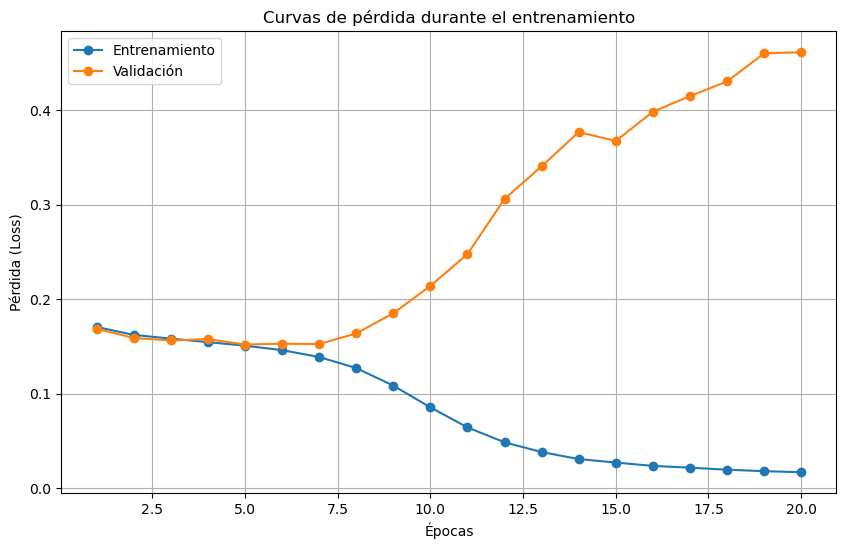

In [26]:
epochs = range(1, len(loss_train) + 1)  # Número de épocas

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_train, label='Entrenamiento', marker='o')
plt.plot(epochs, loss_val, label='Validación', marker='o')
plt.title('Curvas de pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.legend()
plt.grid(True)
plt.savefig(f"{DIR_RESULTS}/loss.{TRAINING_DATE}.png")
plt.show()

#### Precisión

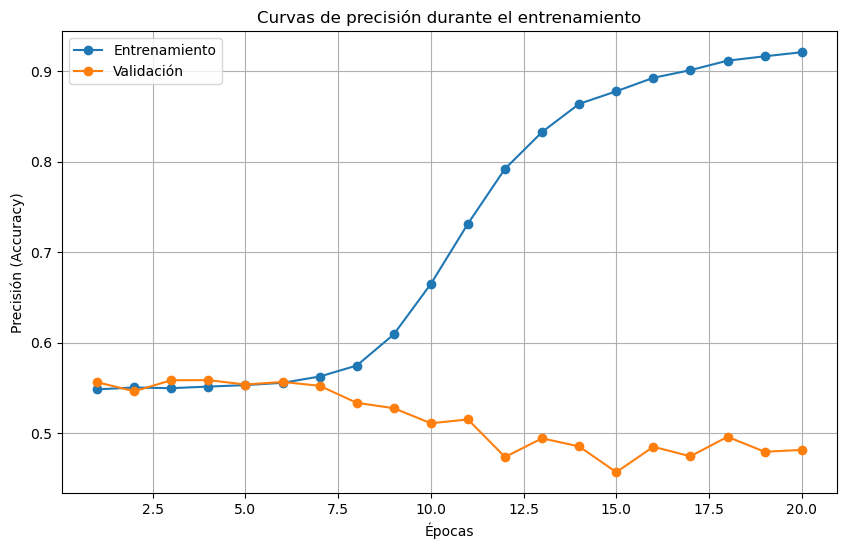

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_train, label='Entrenamiento', marker='o')
plt.plot(epochs, acc_val, label='Validación', marker='o')
plt.title('Curvas de precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión (Accuracy)')
plt.legend()
plt.grid(True)
plt.savefig(f"{DIR_RESULTS}/accuracy.{TRAINING_DATE}.png")
plt.show()

#### Matriz de Confusión

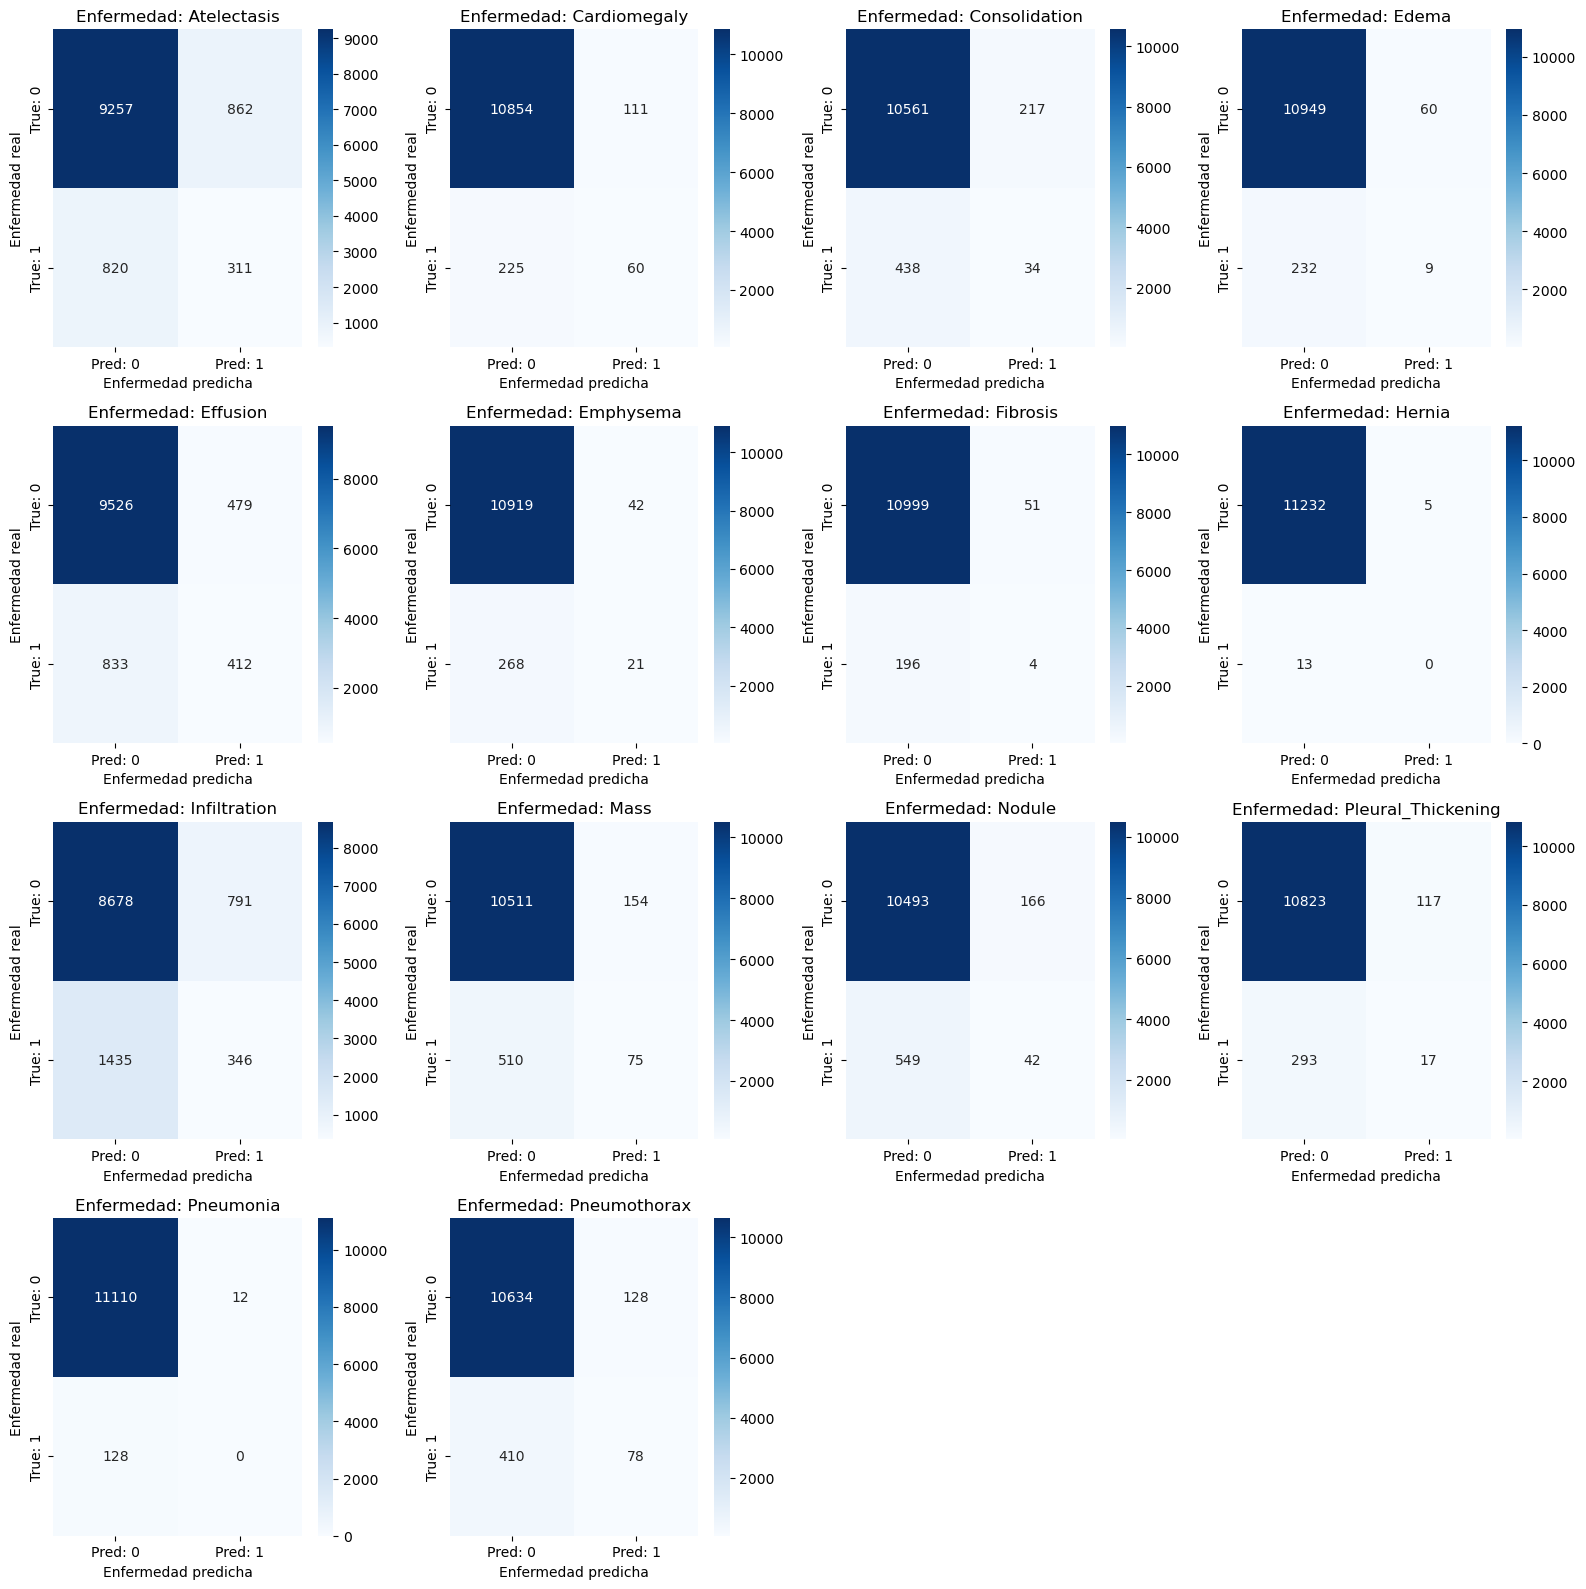

In [28]:
y_true = all_labels.numpy()
y_pred = all_preds.numpy()

# Calcular la matriz de confusión multilabel
mcm = multilabel_confusion_matrix(y_true, y_pred)

num_cols = 4
num_rows = (num_labels + num_cols - 1) // num_cols

# Crear el gráfico con subgráficas
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4*num_rows))

# Aplanar los ejes para poder acceder a ellos de manera más sencilla
axes = axes.flatten()

# Iterar sobre las etiquetas y mostrar cada matriz de confusión
for i in range(num_labels):
    ax = axes[i]
    cm = mcm[i]

    # Visualizamos la matriz de confusión para la etiqueta
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"], ax=ax)
    ax.set_title(f'Enfermedad: {labels_names[i]}')
    ax.set_xlabel('Enfermedad predicha')
    ax.set_ylabel('Enfermedad real')

# Eliminar ejes vacíos
for i in range(num_labels, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(f"{DIR_RESULTS}/confusion_matrix.{TRAINING_DATE}.png")
plt.show()

### Ejemplos de muestras

In [29]:
def plot_predictions_grid(images, true_labels, pred_labels, class_names, num_images=80, rows=20, cols=4):
    # Filtrar imágenes donde true_labels tiene al menos un valor en 1
    mask = (true_labels.sum(dim=1) > 0).cpu().numpy()
    images = [img for img, keep in zip(images, mask) if keep]
    true_labels = true_labels[mask]
    pred_labels = pred_labels[mask]

    # Asegurarse de no exceder el número de imágenes
    num_images = min(num_images, len(images))
    fig = plt.figure(figsize=(cols * 3, rows * 3))

    for i in range(num_images):
        img = images[i].cpu().numpy()

        # Convertir a escala de grises si tiene 3 canales
        if img.shape[0] == 3:
            img = img.mean(axis=0)

        true_label = true_labels[i].cpu().numpy()
        pred_label = pred_labels[i].cpu().numpy()

        # Crear texto verde para etiquetas reales
        true_text = "True: "
        for j in range(len(class_names)):
            if true_label[j] == 1:
                color = "green" if pred_label[j] == 1 else "red"
                true_text += f"{class_names[j]} "  # Agregar etiqueta con color

        # Crear texto rojo para las predicciones
        pred_text = "Pred: "
        for j in range(len(class_names)):
            if pred_label[j] == 1:
                color = "green" if true_label[j] == 1 else "red"
                pred_text += f"{class_names[j]} "

        # Mostrar imagen
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        ax.text(
            0.5,
            -0.1,
            true_text,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )
        ax.text(
            0.5,
            -0.2,
            pred_text,
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )

    plt.tight_layout()
    plt.show()
    return fig

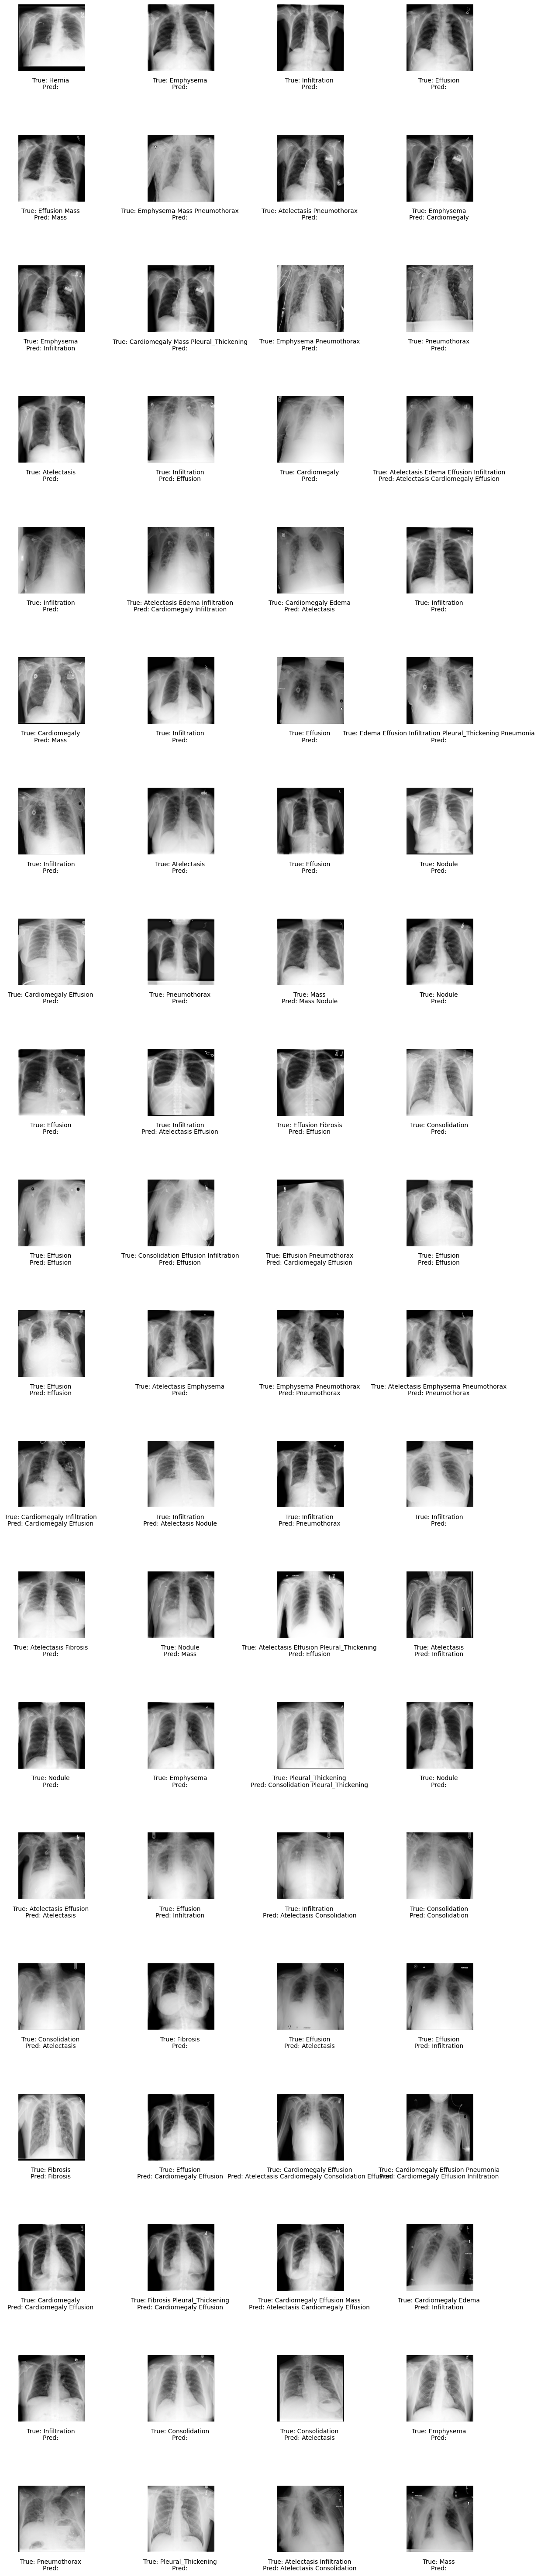

In [30]:
fig_samples = plot_predictions_grid(test_images, all_labels, all_preds, labels_names, num_images=80, rows=20, cols=4)
fig_samples.savefig(f"{DIR_RESULTS}/fig_samples.{TRAINING_DATE}.png")

### Genera el informe

In [31]:
def add_dataframe(pdf, df):
	pdf.set_font('Arial', '', 8)
	pdf.ln(10)

	col_widths = []
	for col in df.columns:
		max_width = max(df[col].astype(str).apply(len).max(), len(col))
		col_widths.append(max_width * 2)

	index_width = max(df.index.astype(str).map(len).max(), len(str(df.index.name) if df.index.name else '#')) * 2.7
	col_widths.insert(0, index_width)

	row_height = pdf.font_size * 1.5

	pdf.cell(col_widths[0], row_height, '#', border=1)
	for i, col in enumerate(df.columns):
		pdf.cell(col_widths[i + 1], row_height, col, border=1)
	pdf.ln(row_height)

	for i in range(len(df)):
		pdf.cell(col_widths[0], row_height, str(df.index[i]), border=1)  # Row number
		for j, col in enumerate(df.columns):
			pdf.cell(col_widths[j + 1], row_height, str(df.iloc[i, j]), border=1)
		pdf.ln(row_height)

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font("Arial", size=12)

# Título
pdf.set_font("Arial", style="B", size=14)
pdf.cell(0, 10, DESCRIPTION, ln=True, align="C")
pdf.cell(0, 10, TRAINING_DATE, ln=True, align="C")
pdf.ln(10)

pdf.set_font("Arial", style="B", size=12)
pdf.cell(0, 10, "Resultados del entrenamiento", ln=True, align="L")
add_dataframe(pdf, results_df)
pdf.ln(10)

pdf.set_font("Arial", style="B", size=12)
pdf.cell(0, 10, "Métricas de Validación", ln=True, align="L")
add_dataframe(pdf, report_df)

pdf.add_page()
pdf.image(f"{DIR_RESULTS}/loss.{TRAINING_DATE}.png", x=10, w=190)
pdf.ln(10)
pdf.image(f"{DIR_RESULTS}/accuracy.{TRAINING_DATE}.png", x=10, w=190)

pdf.add_page()
pdf.image(f"{DIR_RESULTS}/confusion_matrix.{TRAINING_DATE}.png", x=10, w=190)

pdf.add_page()
pdf.image(f"{DIR_RESULTS}/fig_samples.{TRAINING_DATE}.png", x=10, w=190)

output_path = f"{DIR_RESULTS}/Report.{TRAINING_DATE}.pdf"
pdf.output(output_path)
print(f"Informe {output_path} generado.")

Informe Results/Report.2025-01-19-05-34-04.pdf generado.


## Medida de la incertidumbre

In [32]:
def mc_dropout_inference(model, dataloader, num_samples):
    # Configurar el modelo en modo evaluación
    model.eval()

    # Activar capa Dropout
    for module in model.modules():
        if module.__class__.__name__.startswith('Dropout'):
            module.train()

    all_preds = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(DEVICE)
            batch_preds = []

            for _ in range(num_samples):
                outputs = model(images)
                probs = torch.sigmoid(outputs)
                batch_preds.append(probs.cpu().numpy())

            batch_preds = torch.tensor(np.array(batch_preds))
            all_preds.append(batch_preds)

    all_preds = torch.cat(all_preds, dim=1)
    pred_mean = torch.mean(all_preds, dim=0)
    pred_var = torch.var(all_preds, dim=0)

    return pred_mean, pred_var

In [33]:
# Evaluar con MC Dropout
pred_mean, pred_var = mc_dropout_inference(model, test_loader, SAMPLES_MC_DROPOUT)

### Estadísticas globales

In [34]:
mean_var_mean = pred_var.mean().item()  # Media de las varianzas
mean_var_std = pred_var.std().item()   # Desviación estándar de las varianzas

print(f"Media de las varianzas: {mean_var_mean:.4f}")
print(f"Desviación estándar de las varianzas: {mean_var_std:.4f}")

Media de las varianzas: 0.0018
Desviación estándar de las varianzas: 0.0082


### Resumen general

In [35]:
image_names = test_data[COLUMN_IMAGE].apply(os.path.basename).tolist()
mean_df = pd.DataFrame(pred_mean.numpy(), columns=labels_names, index=image_names)
var_df = pd.DataFrame(pred_var.numpy(), columns=labels_names, index=image_names)

# Combinar medias y varianzas
summary_df = mean_df.copy()
for col in labels_names:
    summary_df[col] = mean_df[col].map(lambda x: f"{x:.2f}") + " ± " + var_df[col].map(lambda x: f"{x:.2f}")

summary_df.head(20)

Atelectasis Cardiomegaly Consolidation        Edema  \
00000003_002.png  0.06 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000005_002.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000007_000.png  0.59 ± 0.06  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000009_000.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000010_000.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000011_000.png  0.01 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000011_008.png  0.00 ± 0.00  0.03 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000012_000.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_032.png  0.00 ± 0.00  0.00 ± 0.00   0.06 ± 0.00  0.00 ± 0.00   
00000013_035.png  0.01 ± 0.00  0.05 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_042.png  0.02 ± 0.00  0.71 ± 0.04   0.00 ± 0.00  0.00 ± 0.00   
00000013_041.png  0.00 ± 0.00  0.50 ± 0.06   0.00 ± 0.00  0.00 ± 0.00   
00000013_044.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_001.png  0.18 ± 0.02  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000013_011.png  0.07 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000016_000.png  0.00 ± 0.00  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000030_001.png  0.13 ± 0.02  0.00 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   
00000032_011.png  0.02 ± 0.00  0.47 ± 0.04   0.03 ± 0.00  0.00 ± 0.00   
00000032_021.png  0.00 ± 0.00  0.00 ± 0.00   0.02 ± 0.00  0.09 ± 0.02   
00000032_034.png  0.65 ± 0.03  0.93 ± 0.00   0.00 ± 0.00  0.00 ± 0.00   

                     Effusion    Emphysema     Fibrosis       Hernia  \
00000003_002.png  0.00 ± 0.00  0.00 ± 0.00  0.12 ± 0.02  0.20 ± 0.05   
00000005_002.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000007_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000009_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000010_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000011_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000011_008.png  0.00 ± 0.00  0.00 ± 0.00  0.45 ± 0.05  0.02 ± 0.00   
00000012_000.png  0.40 ± 0.07  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_032.png  0.05 ± 0.00  0.28 ± 0.05  0.00 ± 0.00  0.00 ± 0.00   
00000013_035.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_042.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.01 ± 0.00   
00000013_041.png  0.00 ± 0.00  0.00 ± 0.00  0.01 ± 0.00  0.00 ± 0.00   
00000013_044.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_001.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000013_011.png  0.00 ± 0.00  0.10 ± 0.01  0.00 ± 0.00  0.00 ± 0.00   
00000016_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000030_001.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_011.png  0.94 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_021.png  0.03 ± 0.00  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   
00000032_034.png  0.79 ± 0.02  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00   

                 Infiltration         Mass       Nodule Pleural_Thickening  \
00000003_002.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000005_002.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000007_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000009_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000010_000.png  0.00 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000011_000.png  0.04 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000011_008.png  0.06 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000012_000.png  0.00 ± 0.00  0.91 ± 0.01  0.13 ± 0.01        0.00 ± 0.00   
00000013_032.png  0.02 ± 0.00  0.00 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000013_035.png  0.01 ± 0.00  0.54 ± 0.02  0.01 ± 0.00        0.00 ± 0.00   
00000013_042.png  0.00 ± 0.00  0.02 ± 0.00  0.00 ± 0.00        0.00 ± 0.00   
00000013_041.png  1.00 ± 0.00  0.00

### Casos problemáticos

In [36]:
# Identificar patologías inciertas
cases = []
for i, (mean, var) in enumerate(zip(pred_mean, pred_var)):
    for label, m, v in zip(labels_names, mean.numpy(), var.numpy()):
        # Comprobar si la varianza puede hacer que la probabilidad de la etiqueta pase del umbral de predicción
        if v >= UNCERTAINTY_THRESHOLD and ((m < THRESHOLD and (m + v) >= THRESHOLD)  or (m >= THRESHOLD and (m - v) < THRESHOLD)):
            cases.append({
                "Radiografía": image_names[i],
                "Etiqueta Incierta": label,
                "Probabilidad": f"{m:.2f}",
                "Varianza": f"{v:.2f}"
            })

# Crear tabla de casos inciertos
cases_df = pd.DataFrame(cases)
cases_df.head(20)

Radiografía   Etiqueta Incierta Probabilidad Varianza
0   00000013_042.png        Pneumothorax         0.48     0.07
1   00000013_041.png        Cardiomegaly         0.50     0.06
2   00000013_011.png        Pneumothorax         0.47     0.07
3   00000092_000.png              Nodule         0.50     0.05
4   00000118_003.png            Effusion         0.48     0.07
5   00000163_000.png         Atelectasis         0.52     0.05
6   00000165_006.png  Pleural_Thickening         0.55     0.06
7   00000181_033.png       Consolidation         0.52     0.09
8   00000211_036.png           Pneumonia         0.54     0.07
9   00000278_004.png              Nodule         0.45     0.06
10  00000372_012.png        Pneumothorax         0.44     0.09
11  00000426_002.png              Nodule         0.53     0.07
12  00000473_000.png              Nodule         0.56     0.06
13  00000609_001.png         Atelectasis         0.53     0.12
14  00000744_011.png         Atelectasis         0.53     0.06
15  00000751_000.png              Nodule         0.45     0.06
16  00000765_004.png              Nodule         0.54     0.10
17  00000792_000.png            Effusion         0.49     0.07
18  00000869_002.png            Effusion         0.54     0.05
19  00000877_027.png       Consolidation         0.50     0.08

### Distribución de varianzas

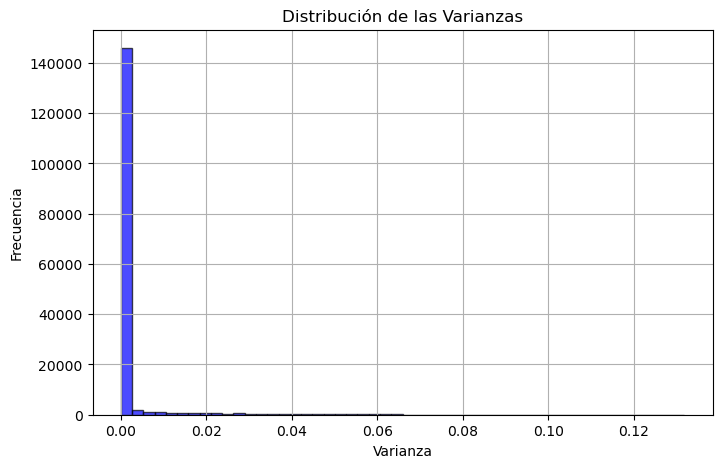

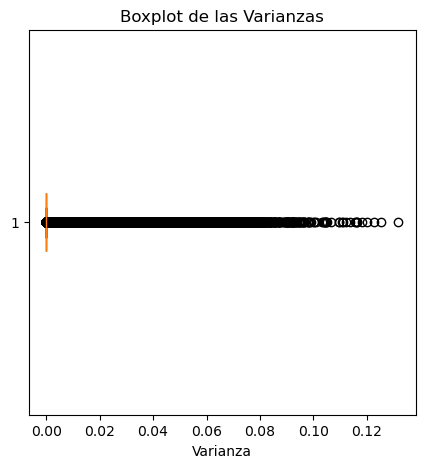

In [37]:
# Aplanar las varianzas para representar todas las etiquetas de todas las imágenes
var_flattened = pred_var.flatten().numpy()

# Histograma
plt.figure(figsize=(8, 5))
plt.hist(var_flattened, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("Distribución de las Varianzas")
plt.xlabel("Varianza")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

# Boxplot
plt.figure(figsize=(5, 5))
plt.boxplot(var_flattened, vert=False, patch_artist=True)
plt.title("Boxplot de las Varianzas")
plt.xlabel("Varianza")
plt.show()

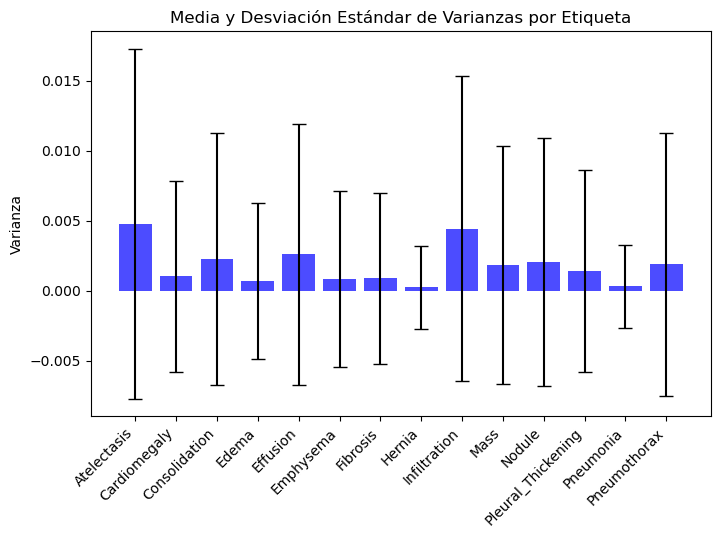

In [38]:
# Media de la varianza por etiqueta.
label_var_mean = pred_var.mean(dim=0).numpy()

# Desviación estándar de la varianza por etiqueta
label_var_std = pred_var.std(dim=0).numpy()

plt.figure(figsize=(8, 5))
plt.bar(labels_names, label_var_mean, yerr=label_var_std, capsize=5, alpha=0.7, color='blue')
plt.title("Media y Desviación Estándar de Varianzas por Etiqueta")
plt.ylabel("Varianza")
plt.xticks(rotation=45, ha="right")  # Rotar 45° y alinear a la derecha
plt.show()

### Visualización

In [39]:
def plot_predictions_grid2(images, true_labels, pred_labels, confidences, variances, class_names, image_names, num_images=80, rows=20, cols=4):
    # Filtrar imágenes donde true_labels tiene al menos un valor en 1
    mask = (true_labels.sum(dim=1) > 0).cpu().numpy()
    images = [img for img, keep in zip(images, mask) if keep]
    true_labels = true_labels[mask]
    pred_labels = pred_labels[mask]
    confidences = confidences[mask]
    variances = variances[mask]
    image_names = [name for name, keep in zip(image_names, mask) if keep]

    # Asegurarse de no exceder el número de imágenes
    num_images = min(num_images, len(images))

    # Calcular el tamaño dinámico basado en el número de etiquetas
    extra_space_per_label = 0.1  # Espacio adicional por etiqueta
    total_extra_space = len(class_names) * extra_space_per_label
    fig_height_per_row = 5 + total_extra_space  # Altura de cada fila ajustada dinámicamente

    # Crear figura con tamaño ajustado
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * fig_height_per_row))
    axes = axes.flatten()  # Convertir a lista para indexar fácilmente

    for i in range(num_images):
        ax = axes[i]

        img = images[i].cpu().numpy()
        if img.shape[0] == 3:
            img = img.mean(axis=0)

        true_label = true_labels[i].cpu().numpy()
        pred_label = pred_labels[i].cpu().numpy()
        confidence = confidences[i].cpu().numpy()
        variance = variances[i].cpu().numpy()
        image_name = image_names[i]

        # Mostrar imagen
        ax.imshow(img, cmap="gray")
        ax.axis("off")

        # Añadir texto: Nombre de la imagen
        ax.text(
            0.5,
            -0.05,
            f"Name: {image_name}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )

        # Añadir texto: True y Pred
        ax.text(
            0.5,
            -0.15,
            f"True: {' '.join([class_names[j] for j in range(len(class_names)) if true_label[j] == 1])}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )
        ax.text(
            0.5,
            -0.25,
            f"Pred: {' '.join([class_names[j] for j in range(len(class_names)) if pred_label[j] == 1])}",
            ha="center",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            color="black",
        )

        # Añadir filas con probabilidades y varianzas
        for j in range(len(class_names)):
            ax.text(
                0.5,
                -0.35 - (0.1 * j),
                f"{class_names[j]}: {confidence[j]:.2f} ± {variance[j]:.2f}",
                ha="center",
                va="top",
                transform=ax.transAxes,
                fontsize=8,
                color="black",
            )

    # Ocultar los ejes vacíos (si hay menos imágenes que subplots)
    for i in range(num_images, len(axes)):
        axes[i].axis("off")

    # Ajustar espacio entre filas y columnas
    plt.subplots_adjust(hspace=1 + total_extra_space, wspace=0.5)
    plt.show()
    return fig

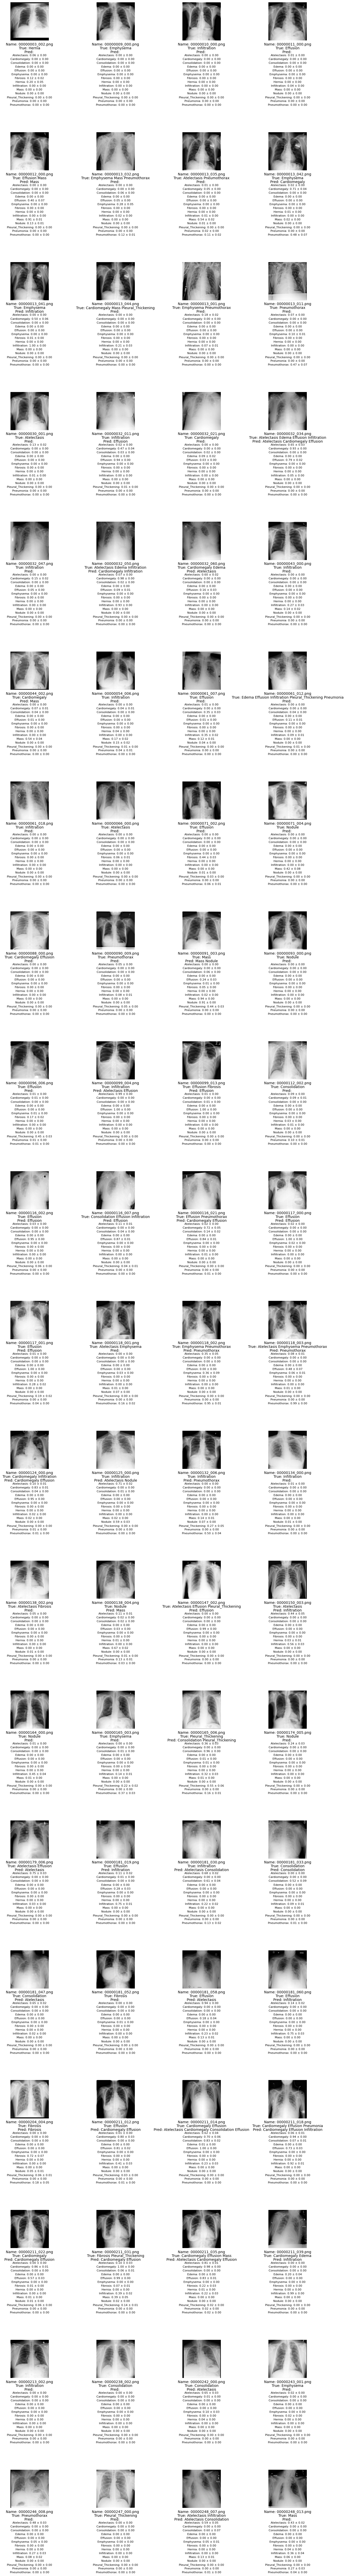

In [40]:
fig_samples = plot_predictions_grid2(test_images, all_labels, all_preds, pred_mean, pred_var, labels_names, image_names, num_images=80, rows=20, cols=4)